<a href="https://colab.research.google.com/github/rajy4683/EVAP2/blob/master/EVA6S9_SingleScript.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Jul  9 17:26:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import sys

Mounted at /content/drive


#### Downloading and installing dependencies from the GitHub link:


In [4]:
!rm -rf /content/mini-Rekog && mkdir /content/model_saves

In [ ]:
!git clone https://github.com/rajy4683/mini-Rekog.git 

In [ ]:
!pip install -r /content/mini-Rekog/requirements.txt

#### WANDB client login

In [7]:
!wandb login a6f947d2d2f69e7a8c8ca0f69811fd554f27d204

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [8]:
sys.path.append('/content/mini-Rekog/')


In [9]:
from miniRekog.utils import fileutils
from miniRekog.config.config import config

In [10]:
!pip install -U albumentations

     |████████████████████████████████| 102kB 5.0MB/s 
     |████████████████████████████████| 38.2MB 1.2MB/s 
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [11]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sys.path.append('/content/mini-Rekog/')
from miniRekog.config.config import config
from miniRekog.models.ResNetModels import S8ResNet
from miniRekog.utils import fileutils
from miniRekog.dataloaders import dataloader
from miniRekog.train.traintest2 import execute_model

from torchsummary import summary
import torch
import torch.optim as optim
import torch.nn as nn
import argparse
import json
import torchvision.transforms as transforms
import torchvision
from torch.optim.lr_scheduler import (StepLR,
    OneCycleLR, MultiStepLR, CyclicLR, ReduceLROnPlateau
)
from albumentations import (
    HorizontalFlip, Compose, RandomCrop, Cutout,Normalize,ShiftScaleRotate, CoarseDropout, 
    Resize,RandomSizedCrop, MotionBlur,PadIfNeeded,Flip, IAAFliplr,ToGray,Rotate,
)

from albumentations.pytorch import ToTensorV2

  pip install torch-lr-finder -v --global-option="amp"


/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:690: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:122: FutureWarning: IAAFliplr is deprecated. Please use HorizontalFlip instead.
  warnings.warn("IAAFliplr is deprecated. Please use HorizontalFlip instead.", FutureWarning)



Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Momentum cycling set to False


torch.Size([512, 3, 32, 32]) tensor([0.0179, 0.0295, 0.0167]) tensor([0.9809, 0.9929, 0.9927])


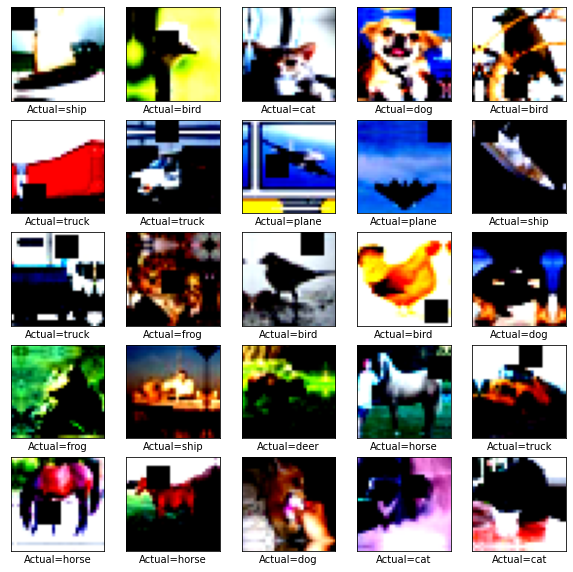

In [ ]:
transform_train = Compose([
    PadIfNeeded(min_height=40, min_width=40,p=1,always_apply=True),
    RandomCrop(32,32,p=1,always_apply=True),
    # PadIfNeeded(min_height=32, min_width=32,p=1,always_apply=True),
    Cutout(1, 8,8,
        fill_value=[0.49139968*255, 0.48215841*255, 0.44653091*255],
        always_apply=False, p=1),
    HorizontalFlip(p=0.5),
    Normalize(
    mean=[0.49139968, 0.48215841, 0.44653091],
    std=[0.24703223, 0.24348513, 0.26158784],
    ),
    # ToGray(p=1),
    ToTensorV2()
])

transform_test = Compose([
    Normalize(
    mean=[0.49421428, 0.48513139, 0.45040909],
    std=[0.24665252, 0.24289226, 0.26159238],
    ),
    ToTensorV2()
])
trainloader, testloader = dataloader.get_train_test_dataloader_cifar10(transform_train=transform_train, 
                                                                    transform_test=transform_test,
                                                                    config=config)
model_new = S8ResNet()

optimizer=optim.SGD(model_new.parameters(), 
                    lr=config.lr,
                    momentum=config.momentum,
                    weight_decay=config.weight_decay)

criterion=nn.CrossEntropyLoss
cycle_momentum = True if config.cycle_momentum == "True" else False
print("Momentum cycling set to {}".format(cycle_momentum))
scheduler = OneCycleLR(optimizer, 
                        config.ocp_max_lr, 
                        epochs=config.epochs, 
                        cycle_momentum=cycle_momentum, 
                        steps_per_epoch=len(trainloader), 
                        base_momentum=config.momentum,
                        max_momentum=0.95, 
                        pct_start=0.208,
                        anneal_strategy=config.anneal_strategy,
                        div_factor=config.div_factor,
                        final_div_factor=config.final_div_factor
                        )

torch.manual_seed(1)
dataiter = iter(trainloader)
images, labels = dataiter.next()

fileutils.show_sample_images(images,labels, dataloader.cifar10_classes)

In [12]:
from torchsummary import summary
from miniRekog.models.ResNetModels import S8ResNet
model_new = S8ResNet()
summary(model_new.to(torch.device("cuda")),input_size=(3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
 ModifiedResBlock-14          [-1, 128,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Learning Rate Range Finder

In [ ]:
config

{'anneal_strategy': 'linear',
 'batch_size': 512,
 'bias': False,
 'cycle_momentum': False,
 'div_factor': 128,
 'dropout': 0.1,
 'epochs': 24,
 'factor': 0.0,
 'final_div_factor': 64,
 'lr': 0.1,
 'lr_decay_threshold': 0.0,
 'lr_policy': 'ocp',
 'momentum': 0.9,
 'no_cuda': False,
 'norm_strategy': 'BatchNorm',
 'ocp_max_lr': 0.5,
 'pct_start': 0.208,
 'project': 'news5',
 'reg_l1': False,
 'reg_l2': False,
 'sched_lr_gamma': 0.5,
 'sched_lr_step': 1,
 'seed': 1,
 'split_pct': 0.208,
 'start_lr': 0,
 'test_batch_size': 128,
 'unfreeze_layer': 3,
 'weight_decay': 0.0}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             Re

Epoch:1.0 val_acc:10.05 loss:2.3041969291687012 lr:0.3073115121672409 
Epoch:2.0 val_acc:9.93 loss:2.298699462890625 lr:0.3148012183683875 
Epoch:3.0 val_acc:12.08 loss:2.2921594993591308 lr:0.3224734614962632 
Epoch:4.0 val_acc:15.44 loss:2.232743671798706 lr:0.3303326902874039 
Epoch:5.0 val_acc:18.89 loss:2.081461637496948 lr:0.33838346190164975 
Epoch:6.0 val_acc:20.02 loss:1.9566839645385743 lr:0.3466304445646065 
Epoch:7.0 val_acc:21.04 loss:1.9217308782577516 lr:0.3550784202745073 
Epoch:8.0 val_acc:21.16 loss:1.8896137634277343 lr:0.36373228757504633 
Epoch:9.0 val_acc:19.33 loss:1.9056892013549804 lr:0.3725970643957907 
Epoch:10.0 val_acc:20.66 loss:1.8915952569961547 lr:0.38167789096181765 
Epoch:11.0 val_acc:20.73 loss:1.875315717124939 lr:0.39098003277426485 
Epoch:12.0 val_acc:23.03 loss:1.854259432220459 lr:0.40050888366352244 
Epoch:13.0 val_acc:23.51 loss:1.8303727996826171 lr:0.4102699689168355 
Epoch:14.0 val_acc:21.62 loss:1.853426495742798 lr:0.4202689484821321 
Epo

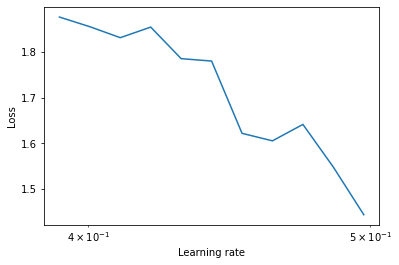

In [ ]:
%load_ext autoreload
%autoreload 2
from miniRekog.train.traintest2 import find_lr_type1

summary(model_new.to(torch.device("cuda")),input_size=(3, 32, 32))


torch.manual_seed(1)
criterion = nn.CrossEntropyLoss()
##3.279445101495624
#0.30585674609910773
#optimizer = optim.SGD(model_new.parameters(), lr=0.279445101495624, weight_decay=0.00020996378493752516,momentum=0.42786879879874073)#-->89.43


optimizer = optim.SGD(model_new.parameters(), lr=0.0000279445101495624, weight_decay=0.0,momentum=0.85)

#traintest.find_lr_type1(model_new, optimizer, criterion, trainloader, seed=1)
lr_finder = find_lr_type1(model_new, 
                          optimizer, 
                          criterion, 
                          trainloader, 
                          testloader=testloader, 
                          seed=1,
                          num_iter=5000,
                          start_lr=0.3,
                          end_lr=1, 
                          step_mode='linear')

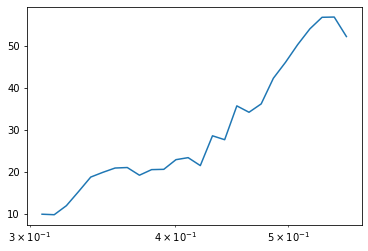

In [ ]:
lrs = lr_finder.history['lr']
acc = lr_finder.history['val_acc']
#plt.plot(acc, np.arange(len(acc)))

plt.plot(lrs,acc)#,lrs)
plt.xscale("log")

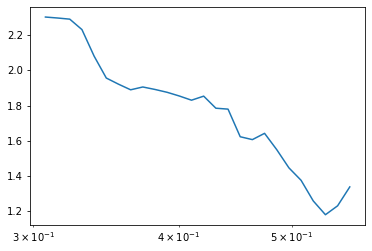

In [ ]:
lrs = lr_finder.history['lr']
acc = lr_finder.history['loss']
#plt.plot(acc, np.arange(len(acc)))

plt.plot(lrs,acc)#,lrs)
plt.xscale("log")

In [ ]:
lr_finder.history.pop('acc')
df_lrf = pd.DataFrame(lr_finder.history)

In [ ]:
df_lrf['loss']#.idxmax()


0     2.304197
1     2.298699
2     2.292159
3     2.232744
4     2.081462
5     1.956684
6     1.921731
7     1.889614
8     1.905689
9     1.891595
10    1.875316
11    1.854259
12    1.830373
13    1.853426
14    1.784718
15    1.779497
16    1.622113
17    1.605770
18    1.641541
19    1.548628
20    1.444929
21    1.373846
22    1.256373
23    1.177837
24    1.228569
25    1.336287
Name: loss, dtype: float64

### 1st Attempt

In [ ]:
!python  /content/mini-Rekog/miniRekog/training_scripts/train_s9eva6.py -p '{"lr":0.015084, "ocp_max_lr":0.5610714913167372, "anneal_strategy":"linear","div_factor":128,"final_div_factor":64, "momentum":0.85, "epochs":24, "weight_decay":0.000000,"batch_size":512}'


  pip install torch-lr-finder -v --global-option="amp"
Setting  lr  =  0.015084
Setting  ocp_max_lr  =  0.5610714913167372
Setting  anneal_strategy  =  linear
Setting  div_factor  =  128
Setting  final_div_factor  =  64
Setting  momentum  =  0.85
Setting  epochs  =  24
Setting  weight_decay  =  0.0
Setting  batch_size  =  512
Final Hyperparameters
dropout: 0.1
batch_size: 512
test_batch_size: 128
lr: 0.015084
momentum: 0.85
no_cuda: False
seed: 1
epochs: 24
bias: False
sched_lr_gamma: 0.5
sched_lr_step: 1
start_lr: 0
weight_decay: 0.0
reg_l1: False
reg_l2: False
norm_strategy: BatchNorm
lr_decay_threshold: 0.0
factor: 0.0
project: news5
ocp_max_lr: 0.5610714913167372
final_div_factor: 64
div_factor: 128
anneal_strategy: linear
pct_start: 0.208
cycle_momentum: False
lr_policy: ocp
split_pct: 0.208
unfreeze_layer: 3
Initializing datasets and dataloaders
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:690: FutureWarning: This class has been deprecated. Pl

### Best Accuracy = 91.63

In [ ]:
!python  /content/mini-Rekog/miniRekog/training_scripts/train_s9eva6.py -p '{"lr":0.015084, "ocp_max_lr":0.1, "anneal_strategy":"linear","div_factor":256,"final_div_factor":128, "momentum":0.9, "epochs":24, "weight_decay":0.000000,"batch_size":512, "cycle_momentum":"False"}'


  pip install torch-lr-finder -v --global-option="amp"
Setting  lr  =  0.015084
Setting  ocp_max_lr  =  0.1
Setting  anneal_strategy  =  linear
Setting  div_factor  =  256
Setting  final_div_factor  =  128
Setting  momentum  =  0.9
Setting  epochs  =  24
Setting  weight_decay  =  0.0
Setting  batch_size  =  512
Setting  cycle_momentum  =  False
Final Hyperparameters
dropout: 0.1
batch_size: 512
test_batch_size: 128
lr: 0.015084
momentum: 0.9
no_cuda: False
seed: 1
epochs: 24
bias: False
sched_lr_gamma: 0.5
sched_lr_step: 1
start_lr: 0
weight_decay: 0.0
reg_l1: False
reg_l2: False
norm_strategy: BatchNorm
lr_decay_threshold: 0.0
factor: 0.0
project: news5
ocp_max_lr: 0.1
final_div_factor: 128
div_factor: 256
anneal_strategy: linear
pct_start: 0.208
cycle_momentum: False
lr_policy: ocp
split_pct: 0.208
unfreeze_layer: 3
Initializing datasets and dataloaders
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:690: FutureWarning: This class has been deprecated

### Loss and Accuracy Plots


In [13]:
from miniRekog.utils import logger
from miniRekog.utils import fileutils
from miniRekog.models.ResNetModels import ResNetLN18
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (15, 10)

import pandas as pd
import plotly.express as px
pd.options.plotting.backend = "plotly"

In [29]:
run_list = ['rajy4683/news5/runs/o0gn8vdb']

runs_df = logger.get_wandb_dataframes(run_list=run_list)
new_df = pd.DataFrame().append(runs_df)

In [30]:
fig = new_df[['Train Accuracy', 'Test Accuracy']].plot()
fig_loss = new_df[['Train Loss', 'Test Loss']].plot()

In [31]:
fig.write_html("/content/EVA6S9_Accuracy.html")
fig_loss.write_html("/content/EVA6S9_Loss.html")

In [33]:
display.HTML("/content/EVA6S9_Accuracy.html")

In [32]:
from IPython import display
display.HTML("/content/EVA6S9_Loss.html")

In [34]:
%load_ext autoreload
%autoreload 2
from miniRekog.train import traintest2
import torch
import torchvision.transforms as transforms
import torchvision
from miniRekog.config.config import config
from miniRekog.dataloaders import dataloader
import torch
from miniRekog.utils.fileutils import plot_misclassified_rgb
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F


device = torch.device("cuda" if not config['no_cuda'] else "cpu")
my_model,acc = traintest2.model_builder2(S8ResNet(), weights_path="/content/model_saves/model-57f1e79283.pt")


transform_test = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.49421428, 0.48513139, 0.45040909), (0.24665252, 0.24289226, 0.26159238))])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                    download=True, transform=transform_test)
testloader = dataloader.get_dataloader(testset, config['batch_size'], shuffle=False, num_workers=2)
#class_accuracy_dict = traintest.classwise_accuracy(my_model, testloader, classes, device=torch.device("cpu"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Files already downloaded and verified


In [35]:

class_accuracy_dict = traintest2.classwise_accuracy(my_model, testloader, dataloader.cifar10_classes, device=torch.device("cuda"))

Accuracy of plane : 93 %
Accuracy of   car : 96 %
Accuracy of  bird : 90 %
Accuracy of   cat : 79 %
Accuracy of  deer : 93 %
Accuracy of   dog : 88 %
Accuracy of  frog : 94 %
Accuracy of horse : 94 %
Accuracy of  ship : 94 %
Accuracy of truck : 94 %


<BarContainer object of 10 artists>

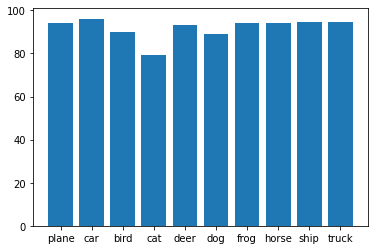

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.bar([key for key in class_accuracy_dict.keys()],[val for val in class_accuracy_dict.values()])

### Misclassifed Images

793
(793,)
92.07 0.2828881721496582


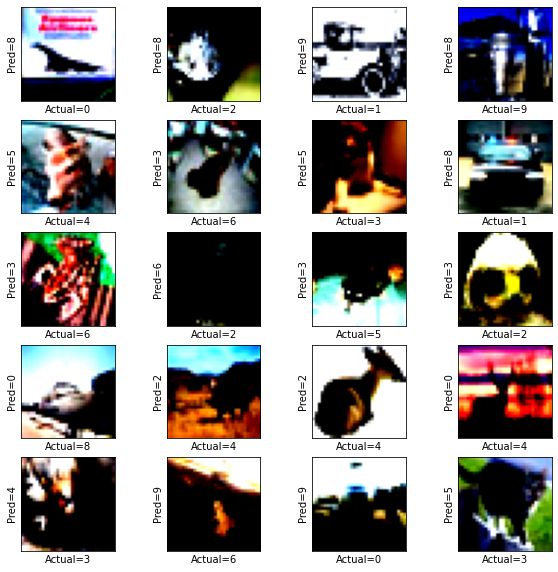

In [37]:
my_model = my_model.to(device)
epoch_test_acc,epoch_test_loss,preds = plot_misclassified_rgb(config, 
                                                          my_model, 
                                                          device, 
                                                          testloader, 
                                                          dataloader.cifar10_classes,
                                                          1)
print(epoch_test_acc,epoch_test_loss)

### Gradcam on Misclassified images

Here preds contains the misclassified images obtained in above cell.

We have plotted the GradCam w.r.t layer2 where saliency maps are 16x16

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning:

nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.



saliency_map size : torch.Size([8, 8])
saliency_map size : torch.Size([8, 8])
saliency_map size : torch.Size([8, 8])
saliency_map size : torch.Size([8, 8])
saliency_map size : torch.Size([8, 8])
saliency_map size : torch.Size([8, 8])
saliency_map size : torch.Size([8, 8])
saliency_map size : torch.Size([8, 8])
saliency_map size : torch.Size([8, 8])
saliency_map size : torch.Size([8, 8])
saliency_map size : torch.Size([8, 8])
saliency_map size : torch.Size([8, 8])
saliency_map size : torch.Size([8, 8])
saliency_map size : torch.Size([8, 8])
saliency_map size : torch.Size([8, 8])
saliency_map size : torch.Size([8, 8])
saliency_map size : torch.Size([8, 8])
saliency_map size : torch.Size([8, 8])
saliency_map size : torch.Size([8, 8])
saliency_map size : torch.Size([8, 8])


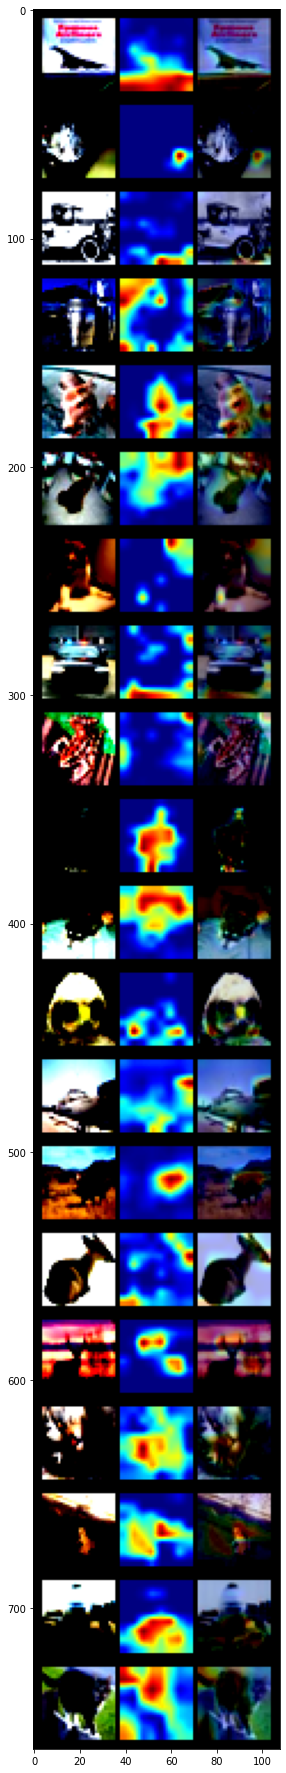

In [38]:
import torchvision.models as models
from torchvision.utils import make_grid, save_image
from miniRekog.utils.gradcam2 import *
new_image_list = []


for img_in in preds:
    new_image_list.append(generate_gradcam_images(img_in, my_model, "layer2"))

fig = plt.figure(figsize=(16,32))
grid_op = torchvision.utils.make_grid(new_image_list, nrow=1)
plt.imshow(np.transpose(grid_op, (1, 2, 0)))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning:

nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.



saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])


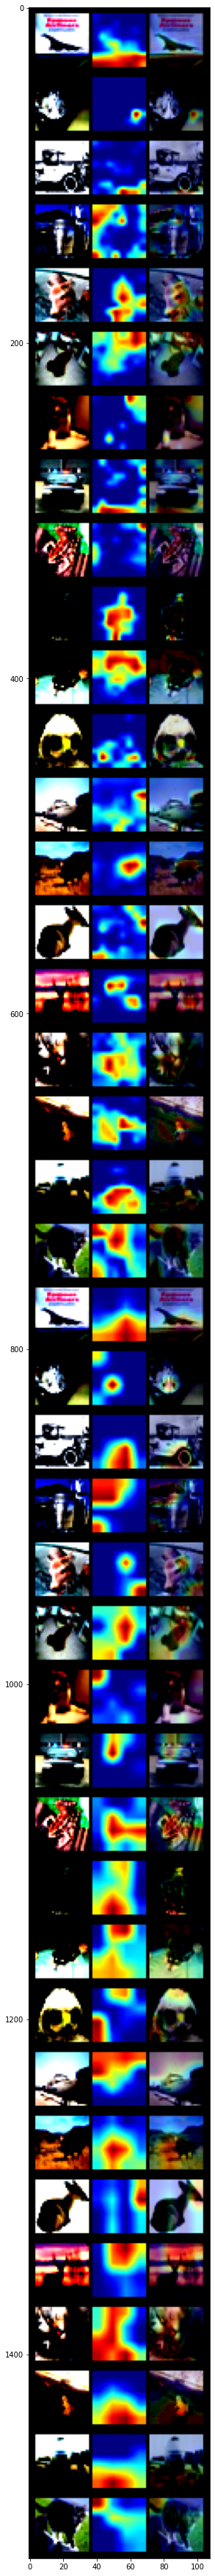

In [39]:
for img_in in preds:
    new_image_list.append(generate_gradcam_images(img_in, my_model, "layer3"))

fig = plt.figure(figsize=(16,64))
grid_op = torchvision.utils.make_grid(new_image_list, nrow=1)
plt.imshow(np.transpose(grid_op, (1, 2, 0)))